In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
#from utils import extract_basic_features

#import wfdb
import os
#import wfdb.processing as wp
import matplotlib.pyplot as plt
from scipy import signal
#from utils import find_noise_features, extract_basic_features
import shutil
import gc
import time
import random as rn
#from lightgbm import LGBMClassifier
from scipy import sparse
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold,StratifiedKFold
#from xgboost import XGBClassifier

import warnings
import scipy.io as sio

#from resnet_ecg.utils import one_hot,get_batches
from resnet_ecg.ecg_preprocess import ecg_preprocessing


from keras.utils import to_categorical
from keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF


path = '/media/jdcloud/'

warnings.filterwarnings("ignore")

config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.Session(config=config)
KTF.set_session(session )

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.set_random_seed(1234)

class Config(object):
    def __init__(self):
        self.conv_subsample_lengths = [1, 2, 1, 2, 1, 2, 1, 2]
        self.conv_filter_length = 32
        self.conv_num_filters_start = 12
        self.conv_init = "he_normal"
        self.conv_activation = "relu"
        self.conv_dropout = 0.5
        self.conv_num_skip = 2
        self.conv_increase_channels_at = 2
        self.batch_size = 32#128
        self.input_shape = [2560, 12]#[1280, 1]
        self.num_categories = 2

    @staticmethod
    def lr_schedule(epoch):
        lr = 0.1
        if epoch >= 10 and epoch < 20:
            lr = 0.01
        if epoch >= 20:
            lr = 0.001
        print('Learning rate: ', lr)
        return lr


import keras.backend as K


def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np

path = '/media/jdcloud/'

labels_en = pd.read_csv(path + "kfold_labels_en.csv")
print(labels_en.shape)
print(labels_en.head())

data_info = pd.read_csv(path + "data_info.csv")
print(data_info.head())

train_index = np.arange(6500)

label2_list = data_info[data_info.labels_num == 2].index.tolist()
label3_list = data_info[data_info.labels_num == 3].index.tolist()
label4_list = data_info[data_info.labels_num == 4].index.tolist()
label5_list = data_info[data_info.labels_num == 5].index.tolist()
label6_list = data_info[data_info.labels_num == 6].index.tolist()

train_index = np.insert(train_index, label2_list, label2_list)  # [145:155]

train_index = np.insert(train_index, label3_list, label3_list)
train_index = np.insert(train_index, label3_list, label3_list)

train_index = np.insert(train_index, label4_list, label4_list)
train_index = np.insert(train_index, label4_list, label4_list)
train_index = np.insert(train_index, label4_list, label4_list)

train_index = np.insert(train_index, label5_list, label5_list)
train_index = np.insert(train_index, label5_list, label5_list)
train_index = np.insert(train_index, label5_list, label5_list)
train_index = np.insert(train_index, label5_list, label5_list)

train_index = np.insert(train_index, label6_list, label6_list)
train_index = np.insert(train_index, label6_list, label6_list)
train_index = np.insert(train_index, label6_list, label6_list)
train_index = np.insert(train_index, label6_list, label6_list)
train_index = np.insert(train_index, label6_list, label6_list)

print(train_index.dtype)

train_index = train_index.astype(np.int)

train_index.sort()

print("train_index shape :",train_index.shape)
print(train_index)

(7703, 13)
   File_name  age  dataSize  label1  label2  label3  label4  label5  label6  \
0  TRAIN0001   63      5000     8.0     NaN     NaN     NaN     NaN     NaN   
1  TRAIN0002   51      5000     8.0     NaN     NaN     NaN     NaN     NaN   
2  TRAIN0003   85      5000     8.0     NaN     NaN     NaN     NaN     NaN   
3  TRAIN0004   69      5000     8.0     NaN     NaN     NaN     NaN     NaN   
4  TRAIN0005   76      5000     8.0     NaN     NaN     NaN     NaN     NaN   

   label7  label8  labels_num     sex  
0     NaN     NaN           1  FEMALE  
1     NaN     NaN           1    MALE  
2     NaN     NaN           1    MALE  
3     NaN     NaN           1  FEMALE  
4     NaN     NaN           1  FEMALE  
   File_name  label1  label2  label3  label4  label5  label6  label7  label8  \
0  TRAIN0001       8     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1  TRAIN0002       8     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2  TRAIN0003       8     NaN     N

In [3]:
def preprocess_y(labels,y,num_class=9):
    bin_label = np.zeros((len(y),num_class))
    for i in range(len(y)):
        label_nona = labels.loc[y[i]].dropna()
        for j in range(1,label_nona.shape[0]):
            bin_label[i,int(label_nona[j])]=1
    return bin_label

In [4]:
labels = pd.read_csv(path+"reference.csv")
preprocess_y(labels,[1,2,5,7,8,8,8,8,9])

array([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [8]:
labels["File_name"].values

array(['TRAIN0001', 'TRAIN0002', 'TRAIN0003', ..., 'TRAIN6498',
       'TRAIN6499', 'TRAIN6500'], dtype=object)

In [9]:
import numpy as np
import keras

Using TensorFlow backend.


In [80]:
def read_data_seg(data_path, split="Train", list_ids=[], preprocess=False):
    """ Read data """

    # Fixed params
    fs=500
    newFs=256
    winSecond=10
    winNum=10
    n_index=0   
    n_class = 9
    
    winSize = winSecond * fs
    new_winSize = winSecond * newFs
    # Paths
    path_signals = os.path.join(data_path, split)

    # Read labels and one-hot encode
    # label_path = os.path.join(data_path, "reference.txt")
    # labels = pd.read_csv(label_path, sep='\t',header = None)
    # labels = pd.read_csv("reference.csv")

    # Read time-series data
    channel_files = list_ids#os.listdir(path_signals)
    # print(channel_files)
    #channel_files.sort()
    n_channels = 12  # len(channel_files)

    # Initiate array
    list_of_channels = []
    X = np.zeros((len(channel_files), new_winSize, n_channels)).astype('float32') 
    i_ch = 0

    channel_name = ['V6', 'aVF', 'I', 'V4', 'V2', 'aVL', 'V1', 'II', 'aVR', 'V3', 'III', 'V5']
    channel_mid_name = ['II', 'aVR', 'V2', 'V5']
    channel_post_name = ['III', 'aVF', 'V3', 'V6']

    for i_ch, fil_ch in enumerate(channel_files[:]):  # tqdm
           
        ecg = sio.loadmat(os.path.join(path_signals, fil_ch))
        ecg_length = ecg["I"].shape[1]

        if ecg_length > fs * winNum * winSecond:
            print(" too long !!!", ecg_length)
            ecg_length = fs * winNum * winSecond
        if ecg_length < 4500:
            print(" too short !!!", ecg_length)
            break

        slide_steps = int((ecg_length - winSize) / winSecond)

        if ecg_length <= 4500:
            slide_steps = 0

        ecg_channels = np.zeros((new_winSize, n_channels)).astype('float32') 

        for i_n, ch_name in enumerate(channel_name):

            ecg_channels[:, i_n] = signal.resample(ecg[ch_name]
                                                   [:, n_index * slide_steps:n_index * slide_steps + winSize].T
                                                   , new_winSize).T
            if preprocess:
                data = ecg_preprocessing(ecg_channels[:, i_n].reshape(1, new_winSize), 'sym8', 8, 3, newFs)
                ecg_channels[:, i_n] = data[0]
            else:
                pass
                ecg_channels[:, i_n] = ecg_channels[:, i_n]

        X[i_ch, :, :] = ecg_channels

    return X

def preprocess_y(labels,list_ids,num_class=9):
    
    bin_label = np.zeros((len(list_ids),num_class)).astype('int8') 
    for id_n in list_ids:
        id_n = id_n.strip('.mat')
        label_nona = labels[labels.File_name==id_n].iloc[0].dropna()#labels.loc[y[i]].dropna()
        
        for j in range(1,label_nona.shape[0]):
            bin_label[i,int(label_nona[j])]=1
            
    return bin_label

def add_compile(model, config):
    optimizer = SGD(lr=config.lr_schedule(0), momentum=0.9)  # Adam()#
    model.compile(loss='binary_crossentropy',  # weighted_loss,#'binary_crossentropy',
                  optimizer='adam',  # optimizer,#'adam',
                  metrics=['accuracy', fmeasure, precision])#recall

In [85]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, path,list_ids,labels,batch_size=64, dim=2560, n_channels=12, n_classes=9,shuffle=True):
        self.path = path
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_ids = list_ids
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        
        return int(np.floor(len(self.list_ids))/self.batch_size)
    
    def __getitem__(self, index):
        "generate one batch"
        
        # generate indexes of the batch 
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # find list od ids
        list_ids_t = [self.list_ids[k] for k in indexes]
        
        # generate data
        X, y = self.__data_generation(list_ids_t)
        
    def on_epoch_end(self):
        "update indexes after each epoch"
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_ids_t):
        "generate data containing batch_size samples"
        
        #X = np.empty((self.batch_size,self.dim,self.n_channels), dtype=np.float32)
        #y = np.empty((self.batch_size, self.n_classes),dtype = int)
        
        X = read_data_seg(data_path=self.path, list_ids=list_ids_t)
        
        y = preprocess_y(self.labels,list_ids_t)
        #print(X.shape)
        #print(y.shape)
            
        return X, y#keras.utils.to_categorical(y, num_clases = self.n_classes)

In [1]:
def read_data_seg(data_path, split="Train", preprocess=False, fs=500, newFs=128, winSecond=10, winNum=10, n_index=0):
    """ Read data """

    # Fixed params
    # n_index = 0
    n_class = 9
    winSize = winSecond * fs
    new_winSize = winSecond * newFs
    # Paths
    path_signals = os.path.join(data_path, split)

    # Read labels and one-hot encode
    # label_path = os.path.join(data_path, "reference.txt")
    # labels = pd.read_csv(label_path, sep='\t',header = None)
    # labels = pd.read_csv("reference.csv")

    # Read time-series data
    channel_files = os.listdir(path_signals)
    # print(channel_files)
    channel_files.sort()
    n_channels = 12  # len(channel_files)
    # posix = len(split) + 5

    # Initiate array
    list_of_channels = []

    X = np.zeros((len(channel_files), new_winSize, n_channels)).astype('float32') 
    i_ch = 0

    channel_name = ['V6', 'aVF', 'I', 'V4', 'V2', 'aVL', 'V1', 'II', 'aVR', 'V3', 'III', 'V5']
    channel_mid_name = ['II', 'aVR', 'V2', 'V5']
    channel_post_name = ['III', 'aVF', 'V3', 'V6']

    for i_ch, fil_ch in enumerate(channel_files[:1]):  # tqdm
        
        if i_ch % 3000 == 0:
            print(i_ch)
            
        ecg = sio.loadmat(os.path.join(path_signals, fil_ch))
        ecg_length = ecg["I"].shape[1]

        if ecg_length > fs * winNum * winSecond:
            print(" too long !!!", ecg_length)
            ecg_length = fs * winNum * winSecond
        if ecg_length < 4500:
            print(" too short !!!", ecg_length)
            break

        slide_steps = int((ecg_length - winSize) / winSecond)

        if ecg_length <= 4500:
            slide_steps = 0

        ecg_channels = np.zeros((new_winSize, n_channels)).astype('float32') 

        for i_n, ch_name in enumerate(channel_name):

            ecg_channels[:, i_n] = signal.resample(ecg[ch_name]
                                                   [:, n_index * slide_steps:n_index * slide_steps + winSize].T
                                                   , new_winSize).T
            if preprocess:
                data = ecg_preprocessing(ecg_channels[:,i_n].reshape(1,new_winSize),'sym8',8,3,newFs,True,True)
                ecg_channels[:, i_n] = data[0]
            else:
                pass
                ecg_channels[:, i_n] = ecg_channels[:, i_n]
                
        if i_ch % 5000 == 0:
            print(ecg_channels.shape)
            
        X[i_ch, :, :] = ecg_channels

    return X

In [5]:
path = '/media/jdcloud/'
import os
import numpy as np
import scipy.io as sio
from scipy import signal
test_x_seg0 = read_data_seg(path, split='Val', winSecond=5,n_index=0)

0
(640, 12)


In [10]:
test_x_seg0[2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
from resnet_ecg import attentionmodel  

from keras.layers import Input
from keras.models import Model,load_model

'''   '''
inputs0 = Input(shape=(2560,12),dtype="float32")
inputs1 = Input(shape=(2560,12),dtype="float32")
inputs2 = Input(shape=(2560,12),dtype="float32")
inputs3 = Input(shape=(2560,12),dtype="float32")
inputs4 = Input(shape=(2560,12),dtype="float32")
inputs5 = Input(shape=(2560,12),dtype="float32")
inputs6 = Input(shape=(2560,12),dtype="float32")
inputs7 = Input(shape=(2560,12),dtype="float32")
inputs8 = Input(shape=(2560,12),dtype="float32")
inputs9 = Input(shape=(2560,12),dtype="float32")

inputs_list = [inputs0,inputs1,inputs2,inputs3,inputs4,inputs5,inputs6,inputs7,inputs8,inputs9]

outputs = attentionmodel.build_network(inputs_list,0.5,num_classes=9,block_size=4,relu=False)

model = Model(inputs =inputs_list,outputs=outputs)

#print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
train_dataset_path = path + "/Train/"
val_dataset_path = path + "/Val/"

train_files = os.listdir(train_dataset_path)
train_files.sort()
val_files = os.listdir(val_dataset_path)
val_files.sort()

In [40]:
labels_en = pd.read_csv(path + "kfold_labels_en.csv")

In [88]:
#print("train_x shape :", train_x.shape)
en_amount = 1
model_path = './tst_model/'

params = {'batch_size':64, 
          'dim':2560, 
          'n_channels':12, 
          'n_classes':9,
          'shuffle':True 
          }

for seed in range(en_amount):
    print("************************")
    n_fold = 3
    n_classes = 9

    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    kf = kfold.split(train_index, labels_en['label1'])
    
    for i, (index_train, index_valid) in enumerate(kf):
        print('fold: ', i+1, ' training')
        
        index_tr = train_index[index_train]
        index_vld = train_index[index_valid]
        
        train_generate = DataGenerator(path,[train_files[i] for i in index_tr],labels,**params)
        val_generate = DataGenerator(path,[train_files[i] for i in index_vld],labels,**params)
        
        checkpointer = ModelCheckpoint(filepath=model_path+'tst_weights-best_k{}_r{}.hdf5'.format(seed,i),
                                       monitor='val_fmeasure', verbose=1, save_best_only=True,
                                       save_weights_only=True,
                                       mode='max')  # val_fmeasure
        reduce = ReduceLROnPlateau(monitor='val_fmeasure', factor=0.5, patience=2, verbose=1, min_delta=1e-4,
                                   mode='max')

        config = Config()
        add_compile(model, config)
        ''' 
        model_name = 'resnet21.h5'
        earlystop = EarlyStopping(
            monitor='val_fmeasure',  # 'val_categorical_accuracy',
            patience=10,
        )
        checkpoint = ModelCheckpoint(filepath=model_name,
                                     monitor='val_categorical_accuracy', mode='max',
                                     save_best_only='True')

        lr_scheduler = LearningRateScheduler(config.lr_schedule)
        '''
        callback_lists = [checkpointer, reduce]  # [checkpointer,lr_scheduler]#
        # [checkpointer,earlystop,lr_scheduler]
        # [checkpoint, earlystop,lr_scheduler]

        history = model.fit_generator(generator=train_generate,
                                      validation_data=val_generate,
                                      epochs=20,  # class_weight=cw,#'auto',
                                      verbose=1, 
                                      steps_per_epoch=10,
                                      callbacks=callback_lists)

************************
fold:  1  training
Learning rate:  0.1
Epoch 1/20


KeyboardInterrupt: 

In [ ]:
#print("train_x shape :", train_x.shape)
       
model_path = './attention_model/'

for seed in range(en_amount):
    print("************************")
    n_fold = 3
    n_classes = 9

    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    kf = kfold.split(train_index, labels_en['label1'])

    blend_train = np.zeros((6500, n_classes)).astype('float32') #len(train_x)
    blend_test = np.zeros((500, n_fold, n_classes)).astype('float32') #len(test_x)

    count = 0

    for i, (index_train, index_valid) in enumerate(kf):
        print('fold: ', i+1, ' training')
        t = time.time()

        index_tr = train_index[index_train]
        index_vld = train_index[index_valid]

        '''  '''
        
        X_tr = [ecg12_seg0[index_tr], ecg12_seg1[index_tr], ecg12_seg2[index_tr], ecg12_seg3[index_tr],
                ecg12_seg4[index_tr], ecg12_seg5[index_tr], ecg12_seg6[index_tr], ecg12_seg7[index_tr],
                ecg12_seg8[index_tr], ecg12_seg9[index_tr],
               ]

        X_vld = [ecg12_seg0[index_vld], ecg12_seg1[index_vld], ecg12_seg2[index_vld], ecg12_seg3[index_vld],
                 ecg12_seg4[index_vld], ecg12_seg5[index_vld], ecg12_seg6[index_vld], ecg12_seg7[index_vld],
                 ecg12_seg8[index_vld], ecg12_seg9[index_vld],
               ]
        
        #X_tr = train_x[index_tr]
        #X_vld = train_x[index_vld]
        #print(index_tr)

        y_tr = preprocess_y(labels,index_tr)
        y_vld = preprocess_y(labels,index_vld)

        #print(y_tr.shape)
        #print(y_vld.shape)
        #print(y_tr[:10])
        #print(y_vld[:10])

        checkpointer = ModelCheckpoint(filepath=model_path+'attention_weights-best_k{}_r{}.hdf5'.format(seed,i),
                                       monitor='val_fmeasure', verbose=1, save_best_only=True,
                                       save_weights_only=True,
                                       mode='max')  # val_fmeasure
        reduce = ReduceLROnPlateau(monitor='val_fmeasure', factor=0.5, patience=2, verbose=1, min_delta=1e-4,
                                   mode='max')

        config = Config()
        add_compile(model, config)
        ''' 
        model_name = 'resnet21.h5'
        earlystop = EarlyStopping(
            monitor='val_fmeasure',  # 'val_categorical_accuracy',
            patience=10,
        )
        checkpoint = ModelCheckpoint(filepath=model_name,
                                     monitor='val_categorical_accuracy', mode='max',
                                     save_best_only='True')

        lr_scheduler = LearningRateScheduler(config.lr_schedule)
        '''
        callback_lists = [checkpointer, reduce]  # [checkpointer,lr_scheduler]#
        # [checkpointer,earlystop,lr_scheduler]
        # [checkpoint, earlystop,lr_scheduler]

        history = model.fit(x=X_tr, y=y_tr, batch_size=64, epochs=20,  # class_weight=cw,#'auto',
                            verbose=1, validation_data=(X_vld, y_vld), callbacks=callback_lists)

        # Evaluate best trained model
        #model.load_weights(model_path+'densenet_weights-best_k{}_r{}.hdf5'.format(seed, i))

        test_y = model.predict(test_x)
        val_y = model.predict(X_vld)
        
        del X_tr
        del X_vld
        
        #K.clear_session()
        gc.collect()
        gc.collect()
        #config = tf.ConfigProto()
        #config.gpu_options.allow_growth=True
        #sess = tf.Session(config=config)
        #K.set_session(sess)

        blend_train[index_vld, :] = val_y
        blend_test[:, i, :] = test_y

        count += 1


In [55]:
import os
import scipy.io as sio
ecg = sio.loadmat(os.path.join('/media/jdcloud/','Train/TRAIN4011.mat'))

In [56]:
ecg["I"][0].shape

(8000,)

In [57]:
import pywt
db1 = pywt.Wavelet('db1')
coeffs = pywt.wavedec(ecg["V1"][0],db1,level=3)
wave = coeffs[0]

In [58]:
wave.shape

(1000,)

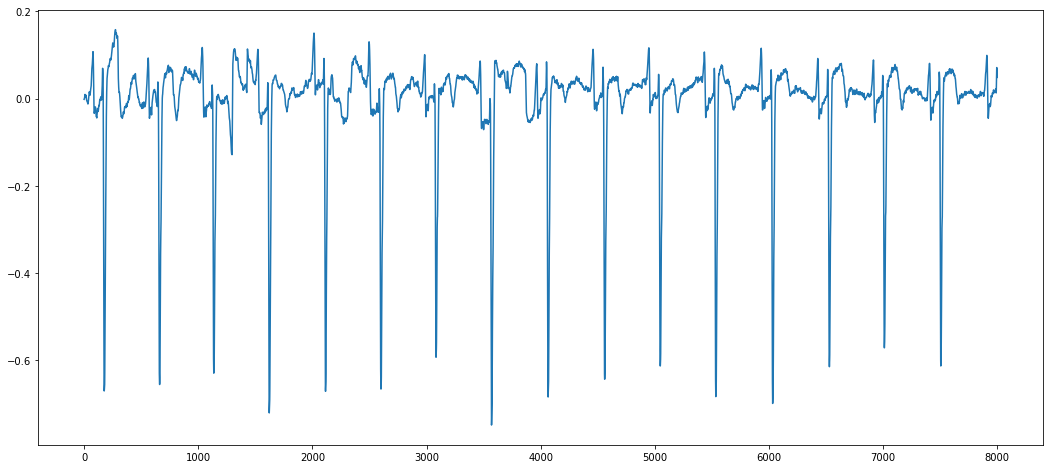

In [59]:
plt.figure(figsize=(18,8))
plt.plot(ecg["V1"][0])
#plt.scatter(hard_peaks, ecg_data[hard_peaks], marker='o', c='r')
#plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
#plt.plot(soft_peaks)
plt.show()

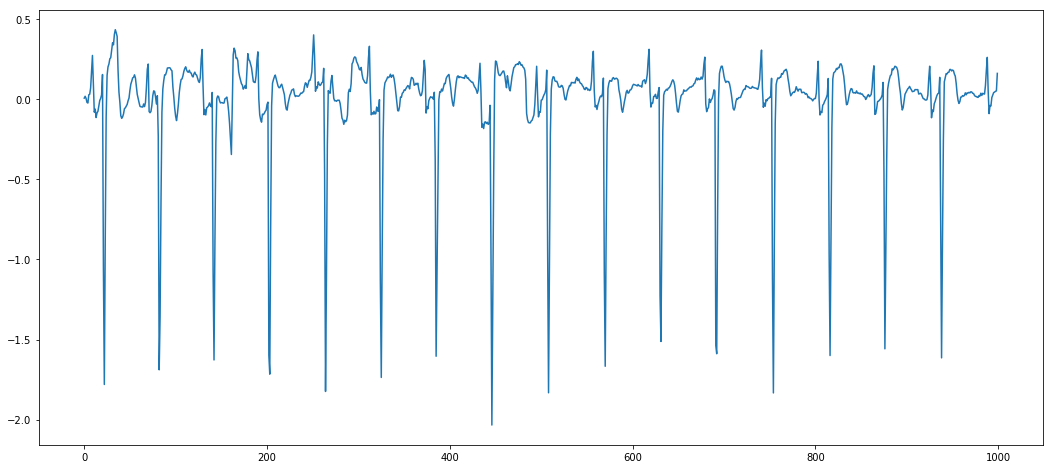

In [60]:
import matplotlib.pyplot as plt
#ecg_data = ecg["data"][0]
#hard_peaks, soft_peaks = wp.find_peaks(ecg_data)
#qrs_inds = wp.xqrs_detect(ecg_data, 500)
# # print hard_peaks
plt.figure(figsize=(18,8))
plt.plot(wave)
#plt.scatter(hard_peaks, ecg_data[hard_peaks], marker='o', c='r')
#plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
#plt.plot(soft_peaks)
plt.show()

In [8]:
from keras.layers import Input
from keras.models import Model,load_model
from resnet_ecg.ecg import resnet15

inputs0 = Input(shape=(2560,12))
inputs1 = Input(shape=(2560,12))
inputs2 = Input(shape=(2560,12))
inputs3 = Input(shape=(2560,12))
inputs4 = Input(shape=(2560,12))
inputs5 = Input(shape=(2560,12))
inputs6 = Input(shape=(2560,12))
inputs7 = Input(shape=(2560,12))
inputs8 = Input(shape=(2560,12))
inputs9 = Input(shape=(2560,12))

inputs_list = [inputs0,inputs1,inputs2,inputs3,inputs4,inputs5,inputs6,inputs7,inputs8,inputs9]

outputs = resnet15.build_network(inputs_list,resBlock_num=8,keep_prob=0.5,num_classes=9)
model = Model(inputs =inputs_list,outputs=outputs)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 2560, 12)     0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           (None, 2560, 12)     0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 2560, 12)     0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 2560, 12)     0                                            
__________________________________________________________________________________________________
input_35 (